# Notebook 6: **Neural Network-Based Rating Prediction**

Welcome to the sixth notebook of our project for AlgorithmArcade Inc. In this notebook, we will develop a neural network model to predict user ratings for courses. Predicting ratings allows us to recommend courses that a user is likely to rate highly, enhancing personalization and user satisfaction.

## **Table of Contents**

1. **Introduction**
2. **Import Libraries**
3. **Load Data**
4. **Preprocessing**
   * Encode User IDs and Course IDs
   * Analyze Rating Distribution
   * Balance the Dataset
   * Prepare the Training and Test Sets
5. **Build the Neural Network Model**
   * Define the Architecture
   * Compile the Model
6. **Train the Model**
7. **Evaluate the Model**
8. **Generate Predictions**
9. **Generate Recommendations**
10. **Extract and Export Embeddings**
11. **Conclusion**
12. **Thanks and Contact Information**

## 1. **Introduction**

In this notebook, we’ll:

   * Use embeddings to represent users and courses.
   * Apply techniques to handle the skewed distribution, such as balancing the dataset by increasing the number of lower ratings.
   * Build a neural network model to predict user ratings for courses.
   * Evaluate the model’s performance.
   * Generate personalized recommendations based on predicted ratings.

## 2. **Import Libraries**

First, let’s import the necessary Python libraries.

In [1]:
from math import sqrt

# Data manipulation libraries
import pandas as pd
import numpy as np

# Neural networks
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn for hyperparameter tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from scipy.stats import randint, uniform
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score,
    classification_report
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For displaying visuals in higher resolution
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set consistent color palette
sns.set_palette('Blues_d')

## 3. **Load Data**

We will load the `user_rating_info.csv` dataset.

In [2]:
# Load user rating data
user_ratings = pd.read_csv('../Data/user_rating_info.csv')
user_ratings.head()

,Unnamed: 0,user_id,course_id,rating
0,0,UID0001293,CID0001,5
1,1,UID0000806,CID0001,3
2,2,UID0000238,CID0001,4
3,3,UID0001129,CID0001,5
4,4,UID0001544,CID0001,3


## 4. **Preprocessing**

Neural networks require numerical inputs. We’ll encode the user IDs and course IDs and prepare the data for training.

### 4.1 Encode User IDs and Course IDs

Generate unique integer IDs for users and courses.

In [3]:
# Encode user IDs
user_encoder = LabelEncoder()
user_ratings['user'] = user_encoder.fit_transform(user_ratings['user_id'])

# Encode course IDs
course_encoder = LabelEncoder()
user_ratings['course'] = course_encoder.fit_transform(user_ratings['course_id'])

Get the number of unique users and courses.

In [4]:
num_users = user_ratings['user'].nunique()
num_courses = user_ratings['course'].nunique()

print(f"Number of users: {num_users}")
print(f"Number of courses: {num_courses}")

Number of users: 2338
Number of courses: 184


### 4.2. Analyze Rating Distribution

Let’s analyze the distribution of ratings to confirm the presence of skewness.

In [5]:
# Distribution of ratings
rating_counts = user_ratings['rating'].value_counts().sort_index()
print("Ratings distribution:")
print(rating_counts)

Ratings distribution:
rating
1     134
2     490
3    1397
4    2696
5    2649
Name: count, dtype: int64


Plot the distribution.

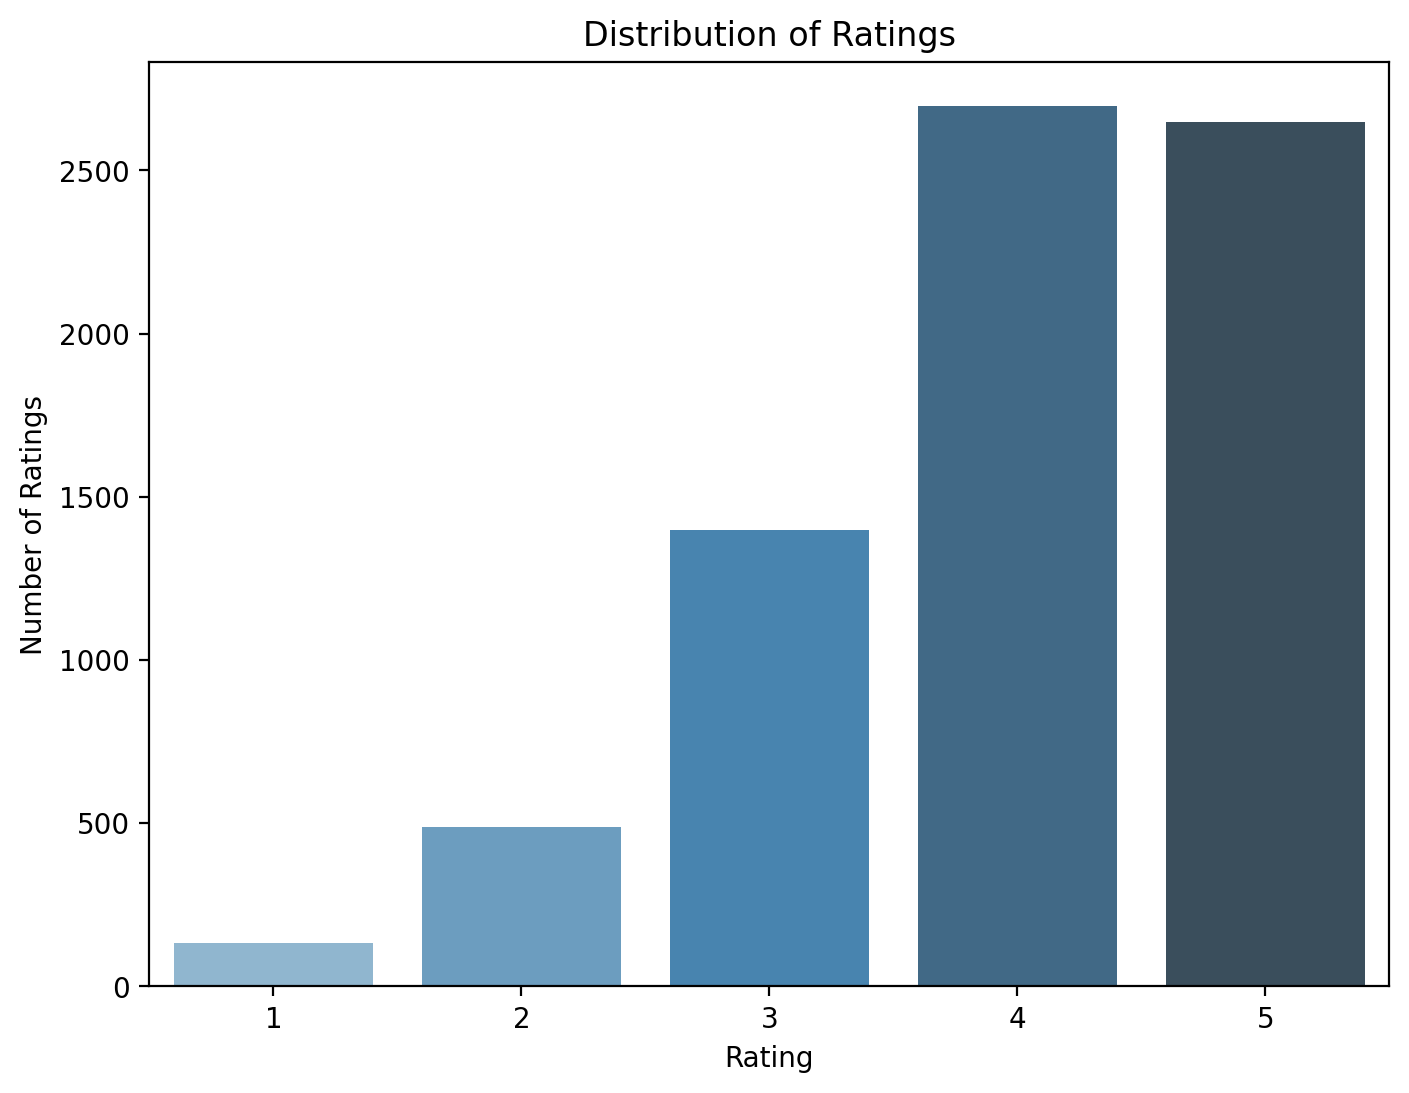

In [6]:
# Bar chart of ratings distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='Blues_d')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

### 4.3 Balance the Dataset

To address the imbalance, we’ll increase the number of lower ratings by oversampling.

Separate the dataset by rating.

In [7]:
# Separate the dataset by rating
rating_1 = user_ratings[user_ratings['rating'] == 1]
rating_2 = user_ratings[user_ratings['rating'] == 2]
rating_3 = user_ratings[user_ratings['rating'] == 3]
rating_4 = user_ratings[user_ratings['rating'] == 4]
rating_5 = user_ratings[user_ratings['rating'] == 5]

Determine the target number of samples

In [8]:
max_count = rating_counts.max()
print(f"Target number of samples per rating: {max_count}")

Target number of samples per rating: 2696


Oversample the minority classes

In [9]:
def oversample_data(df, target_count):
    return resample(df,
                    replace=True,     # Sample with replacement
                    n_samples=target_count,    # To match target count
                    random_state=42)  # Reproducible results

rating_1_oversampled = oversample_data(rating_1, max_count)
rating_2_oversampled = oversample_data(rating_2, max_count)
rating_3_oversampled = oversample_data(rating_3, max_count)

Combine the oversampled data with the majority classes and shuffle the data.

In [10]:
balanced_data = pd.concat([rating_1_oversampled, rating_2_oversampled, rating_3_oversampled, rating_4, rating_5])

# Shuffle the data
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

Verify the new distribution.

New ratings distribution:
rating
1    2696
2    2696
3    2696
4    2696
5    2649
Name: count, dtype: int64


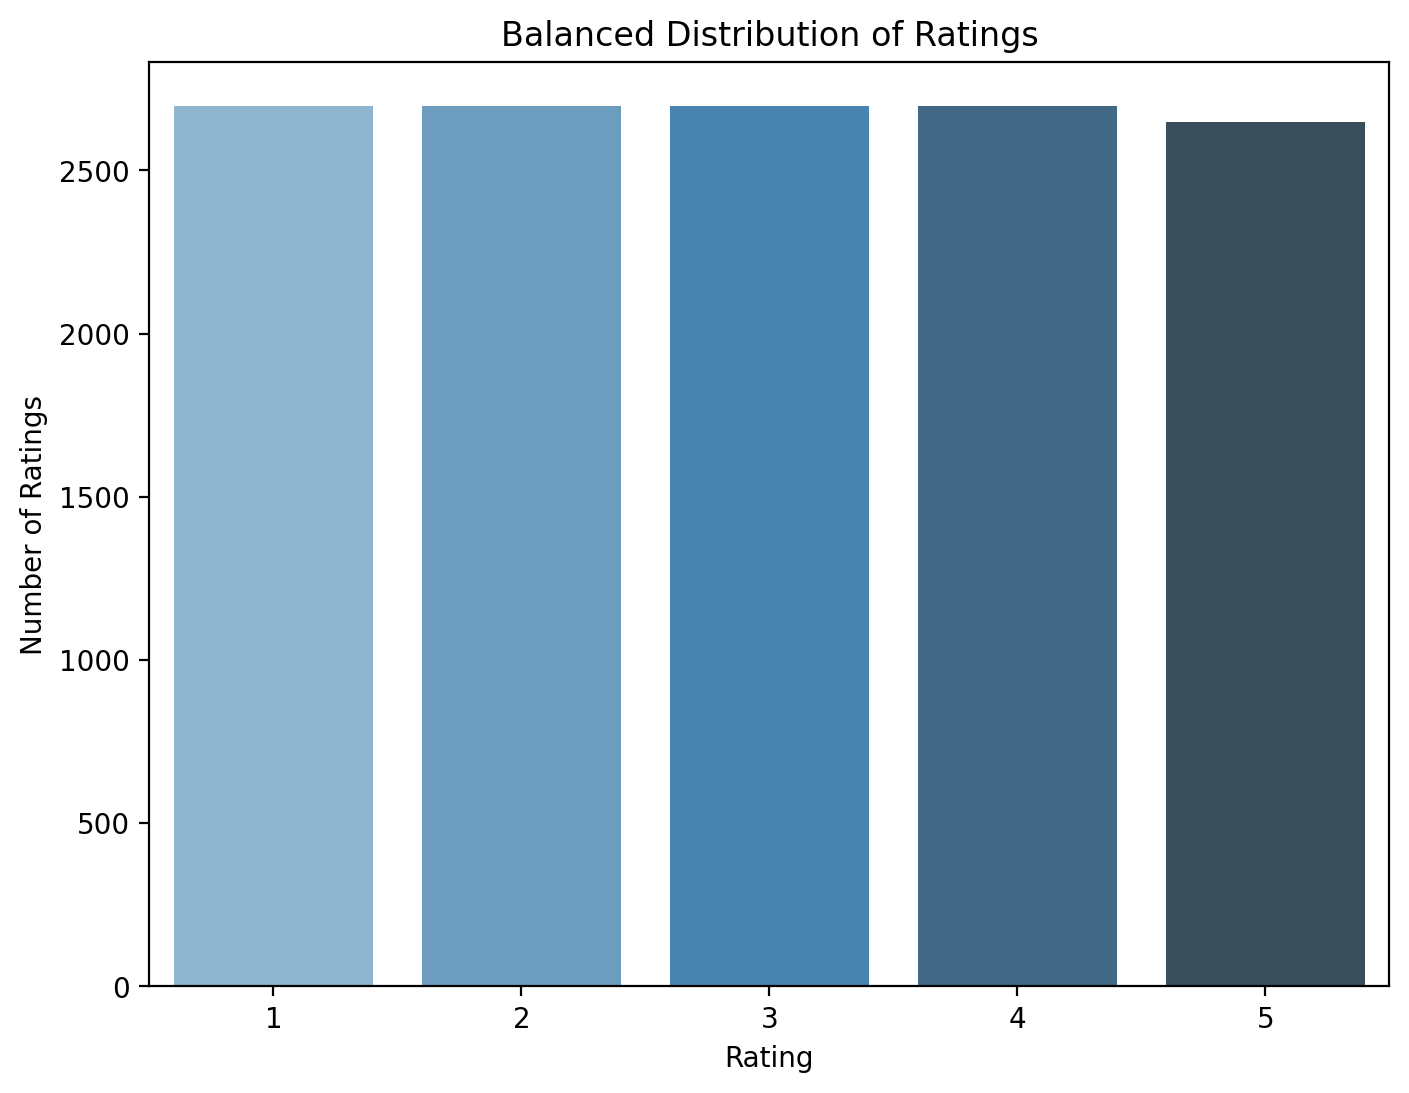

In [11]:
# New distribution of ratings
new_rating_counts = balanced_data['rating'].value_counts().sort_index()
print("New ratings distribution:")
print(new_rating_counts)

# Plot the new distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=new_rating_counts.index, y=new_rating_counts.values, palette='Blues_d')
plt.title('Balanced Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

### 4.4 Prepare the Training and Test Sets

Split the data into training and test sets.

In [12]:
# Features and target
X = balanced_data[['user', 'course']]
y = balanced_data['rating']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 10746
Test samples: 2687


## 5. **Building the Neural Network Model**

We will build a neural network that uses embedding layers to learn user and course representations.

### 5.1 Defining the Architecture

Define the input layers.

In [13]:
# User input
user_input = Input(shape=(1,), name='user_input')

# Course input
course_input = Input(shape=(1,), name='course_input')

Define the embedding layers.

In [14]:
embedding_size = 50

# User embedding
user_embedding = Embedding(
    input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
user_vec = Flatten(name='user_flatten')(user_embedding)

# Course embedding
course_embedding = Embedding(
    input_dim=num_courses, output_dim=embedding_size, name='course_embedding')(course_input)
course_vec = Flatten(name='course_flatten')(course_embedding)

Concatenate user and course embeddings.

In [15]:
# Concatenate user and course vectors
concat = Concatenate()([user_vec, course_vec])

Add hidden layers.

In [16]:
# Add fully connected layers
dense = Dense(256, activation='leaky_relu', name='dense_1')(concat)
dense = Dropout(0.5, name='dropout_1')(dense)
dense = Dense(128, activation='relu', name='dense_2')(dense)
dense = Dense(64, activation='leaky_relu', name='dense_3')(dense)
dense = Dropout(0.1, name='dropout_2')(dense)
dense = Dense(32, activation='relu', name='dense_4')(dense)

Output layer.

In [17]:
# Output layer
output = Dense(1, activation='linear', name='output')(dense)

Define the model.

In [18]:
# Define the model
model = Model(inputs=[user_input, course_input], outputs=output)

### 5.2 Compiling the Model

Compile the model with appropriate loss function and optimizer.

In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

Display the model summary:

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 course_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                116900    ['user_input[0][0]']          
                                                                                                  
 course_embedding (Embeddin  (None, 1, 50)                9200      ['course_input[0][0]']        
 g)                                                                                           

## 6. Training the Model

Prepare inputs for the model.

In [21]:
# Prepare training inputs
train_user = X_train['user'].values
train_course = X_train['course'].values

# Prepare test inputs
test_user = X_test['user'].values
test_course = X_test['course'].values

Use early stopping to prevent overfitting.

In [22]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

Train the model.

In [23]:
# Train the model
history = model.fit(
    x=[train_user, train_course],
    y=y_train,
    batch_size=64,
    epochs=50,
    validation_data=([test_user, test_course], y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
168/168 [==============================] - 0s 2ms/step - loss: 2.7124 - val_loss: 1.1326
Epoch 2/50
168/168 [==============================] - 0s 2ms/step - loss: 0.9774 - val_loss: 1.0294
Epoch 3/50
168/168 [==============================] - 0s 2ms/step - loss: 0.8452 - val_loss: 0.9799
Epoch 4/50
168/168 [==============================] - 0s 2ms/step - loss: 0.7661 - val_loss: 0.8801
Epoch 5/50
168/168 [==============================] - 0s 2ms/step - loss: 0.5790 - val_loss: 0.7616
Epoch 6/50
168/168 [==============================] - 0s 2ms/step - loss: 0.4436 - val_loss: 0.5695
Epoch 7/50
168/168 [==============================] - 0s 2ms/step - loss: 0.3409 - val_loss: 0.5635
Epoch 8/50
168/168 [==============================] - 0s 2ms/step - loss: 0.2670 - val_loss: 0.5164
Epoch 9/50
168/168 [==============================] - 0s 2ms/step - loss: 0.2220 - val_loss: 0.4674
Epoch 10/50
168/168 [==============================] - 0s 2ms/step - loss: 0.1865 - val_loss: 0.4564

## 7. **Evaluating the Model**

Plot the training and validation loss.

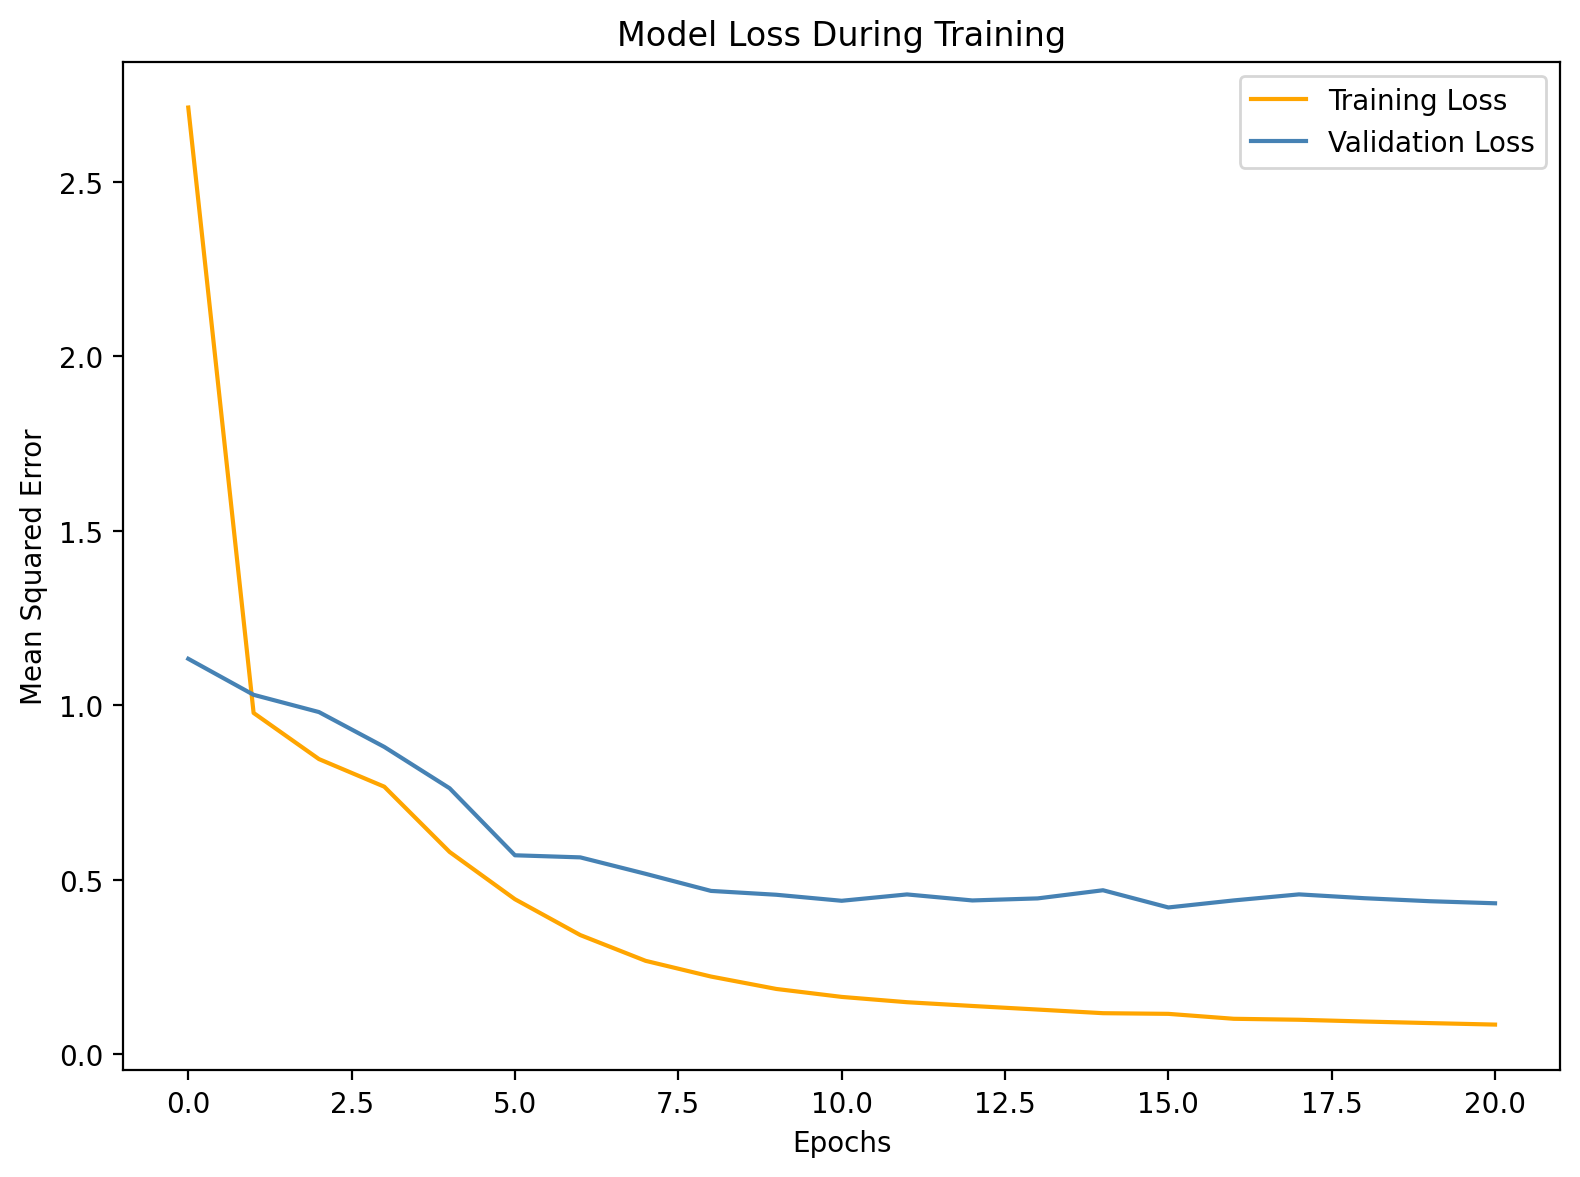

In [24]:
# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='steelblue')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.tight_layout()
plt.show()

Evaluate the model on the test set.

In [25]:
# Evaluate the model
test_loss = model.evaluate([test_user, test_course], y_test)
print(f"Test MSE: {test_loss:.4f}")

84/84 [==============================] - 0s 358us/step - loss: 0.4200
Test MSE: 0.4200


### 7.1 Calculate RMSE

In [26]:
test_rmse = sqrt(test_loss)
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 0.6481


## 8. **Generating Predictions**

Predict ratings on the test set.

In [27]:
# Predict ratings
y_pred = model.predict([test_user, test_course])

84/84 [==============================] - 0s 352us/step


Compare actual and predicted ratings.

In [28]:
# Create a DataFrame to compare
results = pd.DataFrame({
    'user_id': user_encoder.inverse_transform(X_test['user']),
    'course_id': course_encoder.inverse_transform(X_test['course']),
    'rating (actual)': y_test,
    'rating (predicted)': np.round(y_pred.flatten(), 2)
})

results.head(5)

,user_id,course_id,rating (actual),rating (predicted)
7180,UID0001612,CID0022,3,3.65
720,UID0001105,CID0009,1,0.88
3477,UID0001845,CID0002,5,3.64
13272,UID0000082,CID0013,2,1.91
8077,UID0001910,CID0005,4,3.50


## 9. **Generating Recommendations**

We can generate top-N course recommendations for each user based on predicted ratings.

In [29]:
def get_top_n_recommendations(user_id, n=10):
    # Encode the user_id
    encoded_user_id = user_encoder.transform([user_id])[0]
    
    # Get all course IDs
    all_course_ids = np.arange(num_courses)
    
    # Get courses the user has already rated
    user_data = user_ratings[user_ratings['user_id'] == user_id]
    rated_courses = user_data['course'].values
    
    # Courses the user hasn't rated yet
    courses_to_predict = np.setdiff1d(all_course_ids, rated_courses)
    
    # Prepare inputs
    user_array = np.full(len(courses_to_predict), encoded_user_id)
    course_array = courses_to_predict
    
    # Predict ratings
    predicted_ratings = model.predict([user_array, course_array]).flatten()
    
    # Get top-N course IDs
    top_indices = predicted_ratings.argsort()[-n:][::-1]
    top_course_ids = course_array[top_indices]
    
    # Decode course IDs to original IDs
    recommended_course_ids = course_encoder.inverse_transform(top_course_ids)
    
    return recommended_course_ids

**Example Recommendations for a User:**

In [30]:
# Example user
user_id_example = user_ratings['user_id'].iloc[0]  # You can replace this with any user ID from user_ids

# Get top-N recommendations
top_n_courses = get_top_n_recommendations(user_id_example, n=10)

# Get course titles
course_info = pd.read_csv('../Data/course_info.csv')
recommended_titles = course_info[course_info['course_id'].isin(top_n_courses)]['title']
print(f"\nTop recommendations for {user_id_example}:\n")
[print(title) for title in recommended_titles.tolist()]

6/6 [==============================] - 0s 500us/step

Top recommendations for UID0001293:

SQL for Data Science: Managing and Querying Databases
AI in Cybersecurity: Defending Against Digital Threats
Data Cleaning with Python: Ensuring Data Integrity
BI Reporting Tools Expertise: Mastering BI Software
Dashboarding for Business Insights: Visualizing Data Effectively
Serverless Architecture Patterns: Building Modern Applications
Statistical Inference: Drawing Conclusions from Data
Ad-Hoc Reporting: Responding to Business Questions Quickly
Trend Analysis: Identifying Patterns Over Time
High-Performance Computing (HPC) in the Cloud


[None, None, None, None, None, None, None, None, None, None]

## 10. **Extract and Export Embeddings**

Create models to extract embeddings.

In [31]:
# User embedding model
user_embedding_layer = model.get_layer('user_embedding')
user_embedding_weights = user_embedding_layer.get_weights()[0]

# Course embedding model
course_embedding_layer = model.get_layer('course_embedding')
course_embedding_weights = course_embedding_layer.get_weights()[0]

Create DataFrames for embeddings.

In [32]:
# Create DataFrame for user embeddings
user_embeddings = pd.DataFrame(user_embedding_weights)
user_embeddings['user'] = user_encoder.inverse_transform(range(num_users))

# Create DataFrame for course embeddings
course_embeddings = pd.DataFrame(course_embedding_weights)
course_embeddings['course'] = course_encoder.inverse_transform(range(num_courses))

Export embeddings to CSV files.

In [33]:
# Save user embeddings
user_embeddings.to_csv('../Data/user_embeddings.csv', index=False)

# Save course embeddings
course_embeddings.to_csv('../Data/course_embeddings.csv', index=False)

## 11. **Conclusion**

In this notebook, we:

   * Analyzed the skewed distribution of course ratings.
   * Balanced the dataset by oversampling the lower ratings to address the imbalance.
   * Trained the neural network model on the balanced dataset.
   * Evaluated the model’s performance, observing its ability to predict ratings more accurately across all rating levels.
   * Extracted and exported embeddings from the updated model for use in regression and classification models.

#### **Advantages**:

   * Neural networks can model intricate patterns in data.
   * With proper optimization, neural networks can handle large datasets.
   * Embeddings capture underlying factors influencing user preferences.

#### **Limitations**:

   * Neural networks require a substantial amount of data to generalize well.
   * Training neural networks can be resource-intensive.
   * Neural networks are often considered “*black boxes,*” making it hard to interpret learned features.

## 12. **Thanks and Contact Information**

Thank you for reviewing this project notebook. For any further questions, suggestions, or collaborations, please feel free to reach out:

   * [**Email**](mailto:leejoabraham01@gmail.com)
   * [**LinkedIn**](https://www.linkedin.com/in/leejoabraham01)
   * [**GitHub**](https://github.com/LeejoAbraham01)